In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.meteor_score import meteor_score
import skimage.transform
import copy

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [4]:
set_seed(42)

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [9]:
import gdown
import zipfile
import os

google_drive_link = "https://drive.google.com/uc?id=1mehPj1VVwgKyqtqmq4rwkTJTA_tSMD9_"
download_path = "data.zip"
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

gdown.download(google_drive_link, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(download_path)

list_of_files = os.listdir(input_dir)
print("List of files in input directory:")
print(list_of_files)


# Preprocessing Images

In [10]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [11]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [12]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

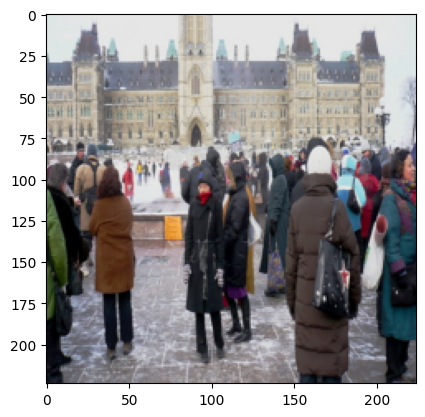

In [13]:
display_image(Images,1)

# Preprocessing Captions

In [14]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [15]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [16]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [17]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [18]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [19]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [20]:
train_split = int(0.8*len(list_of_files))
val_split = (len(list_of_files) - train_split)

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:,:,:,:]

In [21]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [22]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> two men are wrestling in competition <end>', '<start> two men are wrestling while other people are watching <end>', '<start> two men wrestle on the floor in front of an group of young men <end>', '<start> two men wrestling at match <end>', '<start> two young men competing in wrestling tournament <end>']


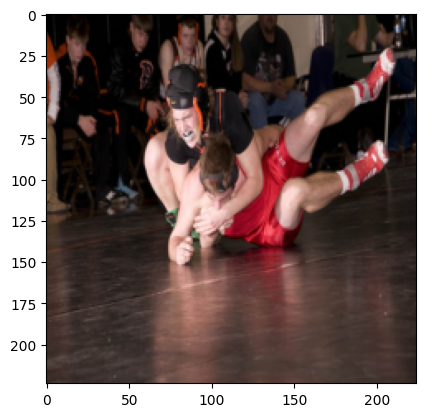

In [23]:
print(train_captions[0])
display_image(train_images,0)

In [24]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7804
6472
6472


# Captions Dataset

In [25]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [26]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [27]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [28]:
class CNN_model_1(nn.Module):
    def __init__(self):
        super(CNN_model_1,self).__init__()
        vgg=models.vgg19(pretrained=True)
        for p in vgg.parameters():
            p.requires_grad_(False)
        modules=list(vgg.children())[:-2]
        self.vgg=nn.Sequential(*modules)
    def forward(self,images):
        features=self.vgg(images)
        features=features.permute(0,2,3,1)
        features=features.view(features.size(0),-1,features.size(-1))
#         print(features.shape)
        return features #(batch_size,49,2048)

# LSTM and Transformer part of the decoder

In [29]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention,self).__init__()
        self.U=nn.Linear(512,512)
        self.W=nn.Linear(512,512)
        self.v=nn.Linear(512,1)
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(1)

    def forward(self,features,hidden_states):
        U_hidden=self.U(hidden_states)#(batch_size,512)
        W_features=self.W(features)#(batch_size,49,512)
        attention=self.tanh(U_hidden.unsqueeze(1)+W_features)
        e=self.v(attention).squeeze(2) #(batch_size,1)
        alpha=self.softmax(e)
        context=(features*alpha.unsqueeze(2)).sum(1)
        return alpha,context

In [30]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention()
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = len(captions[0])-1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds,alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        alphas = []
        word = torch.tensor(vocab[1]['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            if vocab[0][predicted_word_idx.item()] == "<end>":
                break
            captions.append(predicted_word_idx.item())
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        return " ".join([vocab[0][idx] for idx in captions]),alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

# Integrating the 2 parts of the model

In [31]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs,alpha = self.decoder(features,captions)
    return features,outputs,alpha

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.generate_captions(features)
    return prediction


In [32]:
def validate(model):
  actual_captions = []
  generated_captions = []
  total_meteor_score = 0
  for data in tqdm(val_loader):
    image, caption_set = data
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab)[0].split())
    total_meteor_score += round(meteor_score(actual_captions[-1],generated_captions[-1]),4)
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  total_meteor_score /= len(generated_captions)
#   bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'Meteor_score:{total_meteor_score}')
  return total_meteor_score

In [33]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_score = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for (img,cap,caplen) in tqdm(train_loader):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs,alpha = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap[:,1:].reshape(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
                perp = np.exp(loss.item())
            average_loss = average_loss/count
            average_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            score = validate(model)
            if score > best_score:
              print("checkpointing best model")
              best_checkpoint_model = copy.copy(model)
              best_score = score
      return model,best_checkpoint_model

# Calling Functions

In [34]:
learning_rate = 0.0003
num_epochs = 4
embed_size=300
hidden_size=512
attention_size = 256
vocab_size=len(vocab[0])
n_layers=2

In [35]:
# decoder = (embed_size,hidden_size,vocab_size,n_layers)
decoder = DecoderRNN(embed_size,vocab_size,attention_size,512,hidden_size)
encoder = CNN_model_1()
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 72.0MB/s]


In [36]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

Val_dataset consist of 1619 images each with 5 captions, making 8095 captions. and the len of the caption_dataset is defined to be number of captions so, it shows up as 8095 but runs for 1619 images.

Whereas in train, we have restricted the indices so that we run on each image once, so it runs for 6472 images

In [ ]:
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
trainable_params

In [37]:
final_model,best_checkpoint_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 10)

100%|██████████| 6472/6472 [03:03<00:00, 35.25it/s]


Epoch [1/10], Loss: 4.7601, Perplexity: 116.7523


100%|██████████| 8095/8095 [02:21<00:00, 57.33it/s]


BLEU-1: 0.35251953637508754
BLEU-2: 0.19159443873885793
BLEU-3: 0.10425250535508139
BLEU-4: 0.05822900523722245
Meteor_score:0.1861091290920335
checkpointing best model


100%|██████████| 6472/6472 [03:00<00:00, 35.78it/s]


Epoch [2/10], Loss: 4.1457, Perplexity: 63.1590


100%|██████████| 8095/8095 [02:18<00:00, 58.40it/s]


BLEU-1: 0.3413838214453235
BLEU-2: 0.18483113981106536
BLEU-3: 0.10199692611617722
BLEU-4: 0.05433817711086883
Meteor_score:0.1842247683755411


100%|██████████| 6472/6472 [03:00<00:00, 35.76it/s]


Epoch [3/10], Loss: 3.8990, Perplexity: 49.3530


100%|██████████| 8095/8095 [02:16<00:00, 59.50it/s]


BLEU-1: 0.3441089837007423
BLEU-2: 0.19613972526549917
BLEU-3: 0.11251169957754861
BLEU-4: 0.06244224212977282
Meteor_score:0.19619183446572058
checkpointing best model


100%|██████████| 6472/6472 [03:02<00:00, 35.50it/s]


Epoch [4/10], Loss: 3.7765, Perplexity: 43.6631


100%|██████████| 8095/8095 [02:21<00:00, 57.40it/s]


BLEU-1: 0.3632563082342447
BLEU-2: 0.2105872680081102
BLEU-3: 0.12243960823122665
BLEU-4: 0.06826833662559187
Meteor_score:0.20562053119209314
checkpointing best model


100%|██████████| 6472/6472 [03:02<00:00, 35.51it/s]


Epoch [5/10], Loss: 3.6869, Perplexity: 39.9208


100%|██████████| 8095/8095 [02:17<00:00, 58.72it/s]


BLEU-1: 0.3425825066494249
BLEU-2: 0.19326036078891068
BLEU-3: 0.11091830682276105
BLEU-4: 0.0632155521523001
Meteor_score:0.19684925262507708


100%|██████████| 6472/6472 [03:02<00:00, 35.47it/s]


Epoch [6/10], Loss: 3.6315, Perplexity: 37.7676


100%|██████████| 8095/8095 [02:19<00:00, 57.98it/s]


BLEU-1: 0.34814298504429975
BLEU-2: 0.20244817097966503
BLEU-3: 0.11958795482896616
BLEU-4: 0.07151270311743613
Meteor_score:0.19946087708461843


100%|██████████| 6472/6472 [03:01<00:00, 35.71it/s]


Epoch [7/10], Loss: 3.5456, Perplexity: 34.6611


100%|██████████| 8095/8095 [02:19<00:00, 57.94it/s]


BLEU-1: 0.3585733550440183
BLEU-2: 0.20834066728282458
BLEU-3: 0.12097917414079085
BLEU-4: 0.07129759614557335
Meteor_score:0.2066771216800498
checkpointing best model


100%|██████████| 6472/6472 [03:05<00:00, 34.91it/s]


Epoch [8/10], Loss: 3.5068, Perplexity: 33.3425


100%|██████████| 8095/8095 [02:26<00:00, 55.37it/s]


BLEU-1: 0.37644217431967414
BLEU-2: 0.2159157538338079
BLEU-3: 0.1248965234598635
BLEU-4: 0.07045236612342483
Meteor_score:0.2135448672019762
checkpointing best model


100%|██████████| 6472/6472 [03:04<00:00, 34.99it/s]


Epoch [9/10], Loss: 3.4687, Perplexity: 32.0950


100%|██████████| 8095/8095 [02:22<00:00, 56.88it/s]


BLEU-1: 0.3661123058899956
BLEU-2: 0.2095378699668744
BLEU-3: 0.12222905663529031
BLEU-4: 0.06835810184762516
Meteor_score:0.21065546633724563


100%|██████████| 6472/6472 [03:03<00:00, 35.33it/s]


Epoch [10/10], Loss: 3.4145, Perplexity: 30.4011


100%|██████████| 8095/8095 [02:19<00:00, 57.83it/s]


BLEU-1: 0.35326823955059944
BLEU-2: 0.20568211723684146
BLEU-3: 0.12169860540804327
BLEU-4: 0.07105928606888887
Meteor_score:0.2074327486102541


# Generating Captions

In [68]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]

    captions,alphas = model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab)
    print(captions)
    T = transforms.ToPILImage()
    img = T(image.squeeze())
    plt.imshow(img)
    plt.show()
    plt.subplot(4, 5, 1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    words = captions.split(" ")
    for t in range(len(words)):
                        if t > 18:
                            break
                        plt.subplot(4, 5, t+2)
                        plt.text(0, 1, '%s'%(words[t]) , color='black', backgroundcolor='white', fontsize=8)
                        plt.imshow(img)
                        # print(alphas[t])
                        alp_curr = alphas[t].reshape(7,7)
                        alp_img = skimage.transform.pyramid_expand(alp_curr, upscale=224/7, sigma=10)
                        plt.imshow(alp_img, alpha=0.65)
                        plt.axis('off')
    plt.show()
    # visualize_att(image, captions, alphas, smooth=True)
    # heatmap = show_heatmaps(image, alphas)


man is sitting on rock face


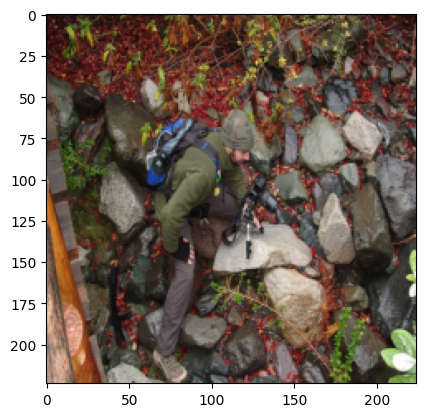

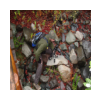

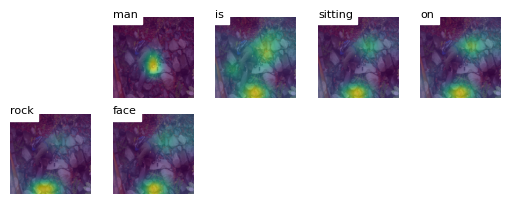

In [72]:
generate_captions_for_random_image(model)

three men play in field


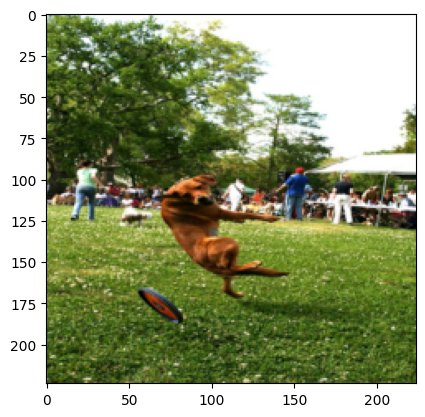

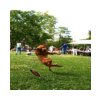

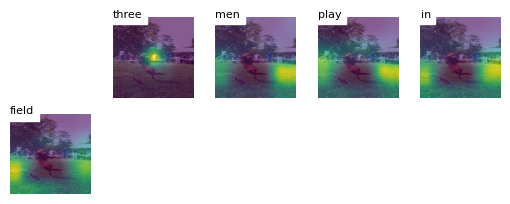

In [73]:
generate_captions_for_random_image(model)

man on bike is riding bicycle on dirt path


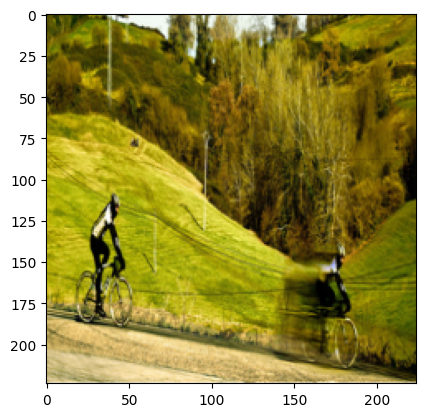

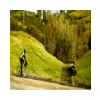

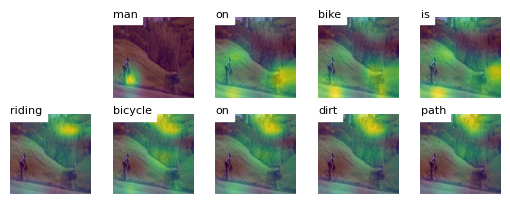

In [81]:
generate_captions_for_random_image(model)

three children are playing in the snow


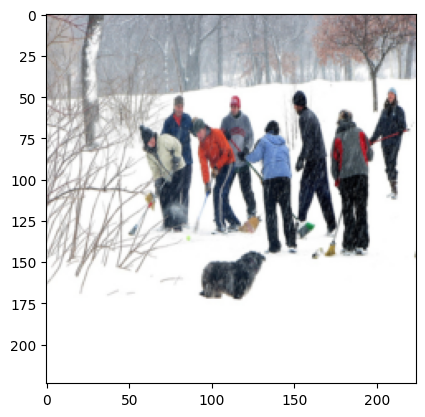

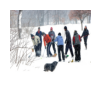

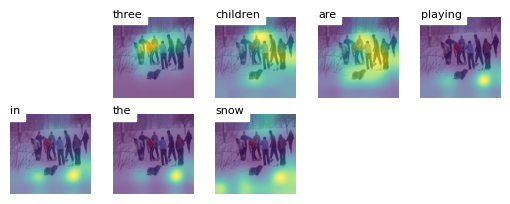

In [78]:
generate_captions_for_random_image(model)

two dogs


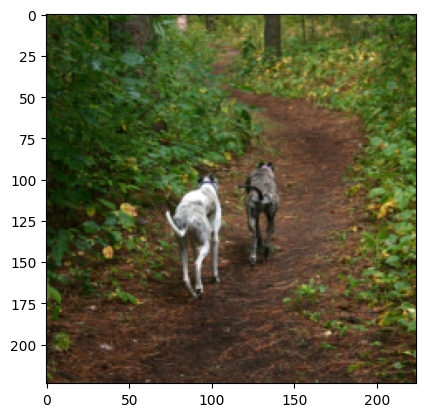

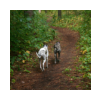

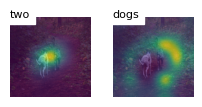

In [86]:
generate_captions_for_random_image(model)

boy in blue shirt is swinging on swing


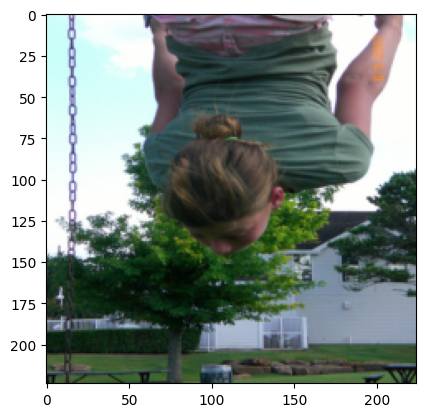

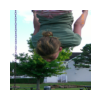

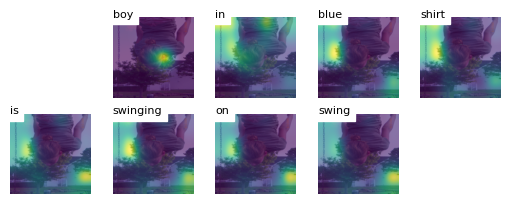

In [80]:
generate_captions_for_random_image(model)